## Dataloader

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_train_val_test_dataloaders(data_dir, batch_size, num_workers=4):
    # Define specific transformations for each dataset
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    # Create datasets using specific transformations
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
    }

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }
    return dataloaders

data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)

In [2]:
import torch
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Models

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def load_resnet50(num_classes):
    model =  models.resnet50(weights='ResNet50_Weights.DEFAULT')
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, num_classes)
    return model

def load_vgg19(num_classes):
    model = models.vgg19(weights='VGG19_Weights.DEFAULT')
    num_features = model.classifier[6].in_features
    model.classifier[6] = nn.Linear(num_features, num_classes)
    return model

def load_efficientnet_b0(num_classes):
    model = models.efficientnet_b0(weights='EfficientNet_B0_Weights.DEFAULT')
    num_features = model.classifier[1].in_features
    model.classifier[1] = nn.Linear(num_features, num_classes)
    return model

def load_mobilenet_v3_large(num_classes):
    model = models.mobilenet_v3_large(weights='MobileNet_V3_Large_Weights.DEFAULT')
    num_features = model.classifier[3].in_features
    model.classifier[3] = nn.Linear(num_features, num_classes)
    return model

## Training

In [4]:
from tqdm import tqdm
import torch
import os

def train_model(model, dataloaders, criterion, optimizer, num_epochs, save_dir):
    # Create directory for saving models if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    train_loader = dataloaders['train']
    test_loader = dataloaders['test']

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct_train += (predicted == labels.float()).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())

                running_val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                predicted = torch.round(torch.sigmoid(outputs))
                correct_val += (predicted == labels.float()).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(test_loader.dataset)
        val_acc = correct_val / total_val

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

        # Save the model after each epoch
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch+1}.pth'))

    print('Training complete.')

## ResNet50

In [6]:
model = load_resnet50(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, save_dir='Checkpoints/resnet50')

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:59<00:00, 10.50it/s]


Epoch [1/10] - Train Loss: 0.2017, Train Acc: 92.11%, Val Loss: 0.1483, Val Acc: 94.25%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:57<00:00, 10.96it/s]


Epoch [2/10] - Train Loss: 0.1470, Train Acc: 94.36%, Val Loss: 0.1106, Val Acc: 95.86%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:57<00:00, 10.85it/s]


Epoch [3/10] - Train Loss: 0.1246, Train Acc: 95.30%, Val Loss: 0.1469, Val Acc: 94.54%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:56<00:00, 11.02it/s]


Epoch [4/10] - Train Loss: 0.1056, Train Acc: 95.97%, Val Loss: 0.1014, Val Acc: 96.31%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.72it/s]


Epoch [5/10] - Train Loss: 0.0920, Train Acc: 96.51%, Val Loss: 0.0915, Val Acc: 96.50%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:59<00:00, 10.52it/s]


Epoch [6/10] - Train Loss: 0.0810, Train Acc: 96.94%, Val Loss: 0.0887, Val Acc: 96.67%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.68it/s]


Epoch [7/10] - Train Loss: 0.0698, Train Acc: 97.36%, Val Loss: 0.0955, Val Acc: 96.45%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.66it/s]


Epoch [8/10] - Train Loss: 0.0612, Train Acc: 97.72%, Val Loss: 0.0812, Val Acc: 97.05%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:59<00:00, 10.47it/s]


Epoch [9/10] - Train Loss: 0.0513, Train Acc: 98.05%, Val Loss: 0.0954, Val Acc: 96.83%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████| 625/625 [00:57<00:00, 10.82it/s]


Epoch [10/10] - Train Loss: 0.0443, Train Acc: 98.33%, Val Loss: 0.0848, Val Acc: 96.95%
Training complete.


## EfficientNet

In [7]:
model = load_efficientnet_b0(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, save_dir='Checkpoints/efficientnet')

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:34<00:00, 18.13it/s]


Epoch [1/10] - Train Loss: 0.1486, Train Acc: 94.28%, Val Loss: 0.1016, Val Acc: 96.47%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:35<00:00, 17.81it/s]


Epoch [2/10] - Train Loss: 0.0989, Train Acc: 96.26%, Val Loss: 0.0767, Val Acc: 97.18%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:34<00:00, 18.06it/s]


Epoch [3/10] - Train Loss: 0.0812, Train Acc: 96.93%, Val Loss: 0.0875, Val Acc: 96.89%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:35<00:00, 17.85it/s]


Epoch [4/10] - Train Loss: 0.0674, Train Acc: 97.46%, Val Loss: 0.1033, Val Acc: 96.14%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:34<00:00, 17.98it/s]


Epoch [5/10] - Train Loss: 0.0574, Train Acc: 97.84%, Val Loss: 0.0638, Val Acc: 97.70%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:34<00:00, 18.03it/s]


Epoch [6/10] - Train Loss: 0.0502, Train Acc: 98.04%, Val Loss: 0.0627, Val Acc: 97.59%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:34<00:00, 17.95it/s]


Epoch [7/10] - Train Loss: 0.0438, Train Acc: 98.36%, Val Loss: 0.0573, Val Acc: 98.04%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:35<00:00, 17.65it/s]


Epoch [8/10] - Train Loss: 0.0384, Train Acc: 98.61%, Val Loss: 0.0671, Val Acc: 97.81%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:34<00:00, 18.04it/s]


Epoch [9/10] - Train Loss: 0.0346, Train Acc: 98.72%, Val Loss: 0.0760, Val Acc: 97.41%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████| 625/625 [00:34<00:00, 17.93it/s]

Epoch [10/10] - Train Loss: 0.0315, Train Acc: 98.84%, Val Loss: 0.0732, Val Acc: 97.40%
Training complete.


## Vgg19

In [5]:
model = load_vgg19(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, save_dir='Checkpoints/vgg19')

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:37<00:00,  6.42it/s]


Epoch [1/10] - Train Loss: 0.7030, Train Acc: 50.16%, Val Loss: 0.6935, Val Acc: 50.00%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:37<00:00,  6.39it/s]


Epoch [2/10] - Train Loss: 0.6937, Train Acc: 49.98%, Val Loss: 0.6933, Val Acc: 50.00%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:39<00:00,  6.31it/s]


Epoch [3/10] - Train Loss: 0.6936, Train Acc: 49.52%, Val Loss: 0.6935, Val Acc: 50.00%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:37<00:00,  6.43it/s]


Epoch [4/10] - Train Loss: 0.6933, Train Acc: 49.77%, Val Loss: 0.6932, Val Acc: 50.00%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:37<00:00,  6.41it/s]


Epoch [5/10] - Train Loss: 0.6933, Train Acc: 49.89%, Val Loss: 0.6931, Val Acc: 50.00%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:37<00:00,  6.43it/s]


Epoch [6/10] - Train Loss: 0.6932, Train Acc: 50.10%, Val Loss: 0.6931, Val Acc: 50.00%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:37<00:00,  6.42it/s]


Epoch [7/10] - Train Loss: 0.6932, Train Acc: 49.70%, Val Loss: 0.6932, Val Acc: 50.00%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:37<00:00,  6.42it/s]


Epoch [8/10] - Train Loss: 0.6932, Train Acc: 49.48%, Val Loss: 0.6932, Val Acc: 50.00%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:36<00:00,  6.44it/s]


Epoch [9/10] - Train Loss: 0.6932, Train Acc: 50.04%, Val Loss: 0.6931, Val Acc: 50.00%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████| 625/625 [01:37<00:00,  6.42it/s]


Epoch [10/10] - Train Loss: 0.6932, Train Acc: 49.93%, Val Loss: 0.6932, Val Acc: 50.00%
Training complete.


## Mobilenet_v3_large

In [6]:
model = load_mobilenet_v3_large(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, save_dir='Checkpoints/mobilenet_v3_large')

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 23.08it/s]


Epoch [1/10] - Train Loss: 0.1522, Train Acc: 94.21%, Val Loss: 0.1749, Val Acc: 93.34%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.77it/s]


Epoch [2/10] - Train Loss: 0.1030, Train Acc: 96.09%, Val Loss: 0.1044, Val Acc: 96.28%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.97it/s]


Epoch [3/10] - Train Loss: 0.0941, Train Acc: 96.48%, Val Loss: 0.0837, Val Acc: 96.95%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.96it/s]


Epoch [4/10] - Train Loss: 0.0731, Train Acc: 97.32%, Val Loss: 0.1129, Val Acc: 95.76%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.82it/s]


Epoch [5/10] - Train Loss: 0.0630, Train Acc: 97.65%, Val Loss: 0.0831, Val Acc: 97.09%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.98it/s]


Epoch [6/10] - Train Loss: 0.0567, Train Acc: 97.90%, Val Loss: 0.0823, Val Acc: 97.01%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.93it/s]


Epoch [7/10] - Train Loss: 0.0493, Train Acc: 98.15%, Val Loss: 0.0697, Val Acc: 97.54%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.91it/s]


Epoch [8/10] - Train Loss: 0.0426, Train Acc: 98.41%, Val Loss: 0.0667, Val Acc: 97.58%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.61it/s]


Epoch [9/10] - Train Loss: 0.0388, Train Acc: 98.58%, Val Loss: 0.0700, Val Acc: 97.89%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████| 625/625 [00:27<00:00, 22.84it/s]

Epoch [10/10] - Train Loss: 0.0356, Train Acc: 98.67%, Val Loss: 0.0705, Val Acc: 97.36%
Training complete.


## Testing

In [7]:
# code to save the figures as high-res PNGs
import os
from pathlib import Path
from matplotlib import pyplot as plt

IMAGES_PATH = Path() / "Images/"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [8]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_test_dataloader(data_dir, batch_size, num_workers=4):
    # Define transformations for the test dataset
    data_transform = transforms.Compose([
        transforms.Resize((244, 244)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    # Create the test dataset
    test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=data_transform)

    # Print the class-to-index mapping
    print("Class to index mapping:", test_dataset.class_to_idx)
    
    # Create the test dataloader
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    return test_loader

data_dir = 'Dataset/'
batch_size = 32
test_loader = create_test_dataloader(data_dir, batch_size)

Class to index mapping: {'FAKE': 0, 'REAL': 1}


In [9]:
from torch import nn
from torchvision import models
from tqdm import tqdm

# Function to load the model
def load_model(model_class, checkpoint_path, num_classes):
    model = model_class(num_classes=num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()
    return model

In [10]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

def evaluate_model(model_name, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())

            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels.float()).sum().item()
            total += labels.size(0)

            # Collect all labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')

    # Generate classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['FAKE', 'REAL']))

    # Confusion Matrix:
    skplt.metrics.plot_confusion_matrix(all_labels, all_predictions)
    save_fig(f"{model_name}_CM")

In [12]:
# List of model loading functions
model_functions = [
    load_resnet50,
    load_efficientnet_b0,
]

checkpoint_paths = [
    'Checkpoints/resnet50/model_epoch_8.pth',
    'Checkpoints/efficientnet/model_epoch_7.pth',
]

model_names = [
    'resnet50',
    'efficientnet'
]

Checkpoints/resnet50/model_epoch_8.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████| 625/625 [00:58<00:00, 10.73it/s]


Test Loss: 0.0812, Test Accuracy: 97.05%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.97      0.97      0.97     10000
        REAL       0.97      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000

Checkpoints/efficientnet/model_epoch_7.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████| 625/625 [00:35<00:00, 17.82it/s]


Test Loss: 0.0573, Test Accuracy: 98.04%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.98      0.98      0.98     10000
        REAL       0.98      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000



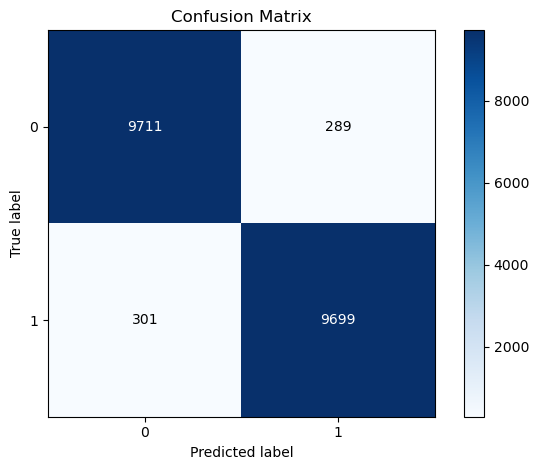

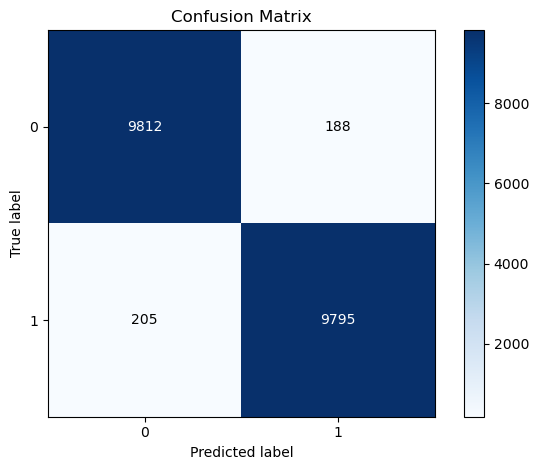

In [13]:
num_classes = 1
loss_fn = nn.BCEWithLogitsLoss()

for get_model, checkpoint_path, model_name in zip(model_functions, checkpoint_paths, model_names):
    # Load the model using the function
    loaded_model = load_model(get_model, checkpoint_path, num_classes)
    loaded_model = loaded_model.to(device)
    # Evaluate the loaded model on the test set
    print(checkpoint_path)
    evaluate_model(model_name, loaded_model, test_loader, loss_fn)